In [1]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [3]:
display(x_train.shape)
display(y_train.shape)

(50000, 784)

(50000,)

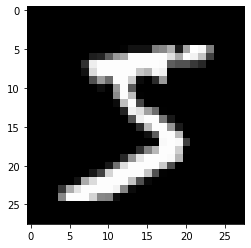

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(x_train[0].reshape(28, 28), cmap="gray")

In [6]:
import torch

def preprocess(x, y):
    return torch.tensor(x).view(-1, 1, 28, 28), torch.tensor(y)

In [7]:
x_train_prep, y_train_prep = preprocess(x_train, y_train)

In [8]:
x_train_prep.size(), y_train_prep.size()

(torch.Size([50000, 1, 28, 28]), torch.Size([50000]))

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
batch_size=32

train_dl = DataLoader(
    TensorDataset(x_train_prep, y_train_prep),
    batch_size=batch_size,
    shuffle=True
)

In [11]:
x_valid_prep, y_valid_prep = preprocess(x_valid, y_valid)

valid_dl = DataLoader(
    TensorDataset(x_valid_prep, y_valid_prep),
    batch_size=batch_size * 2
)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class CNN(nn.Module):
    
    def __init__(self, in_channel):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, 8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [14]:
cnn_test = CNN(1)
cnn_test(x_train_prep[:32]).size()

torch.Size([32, 10])

In [38]:
def run_epoch(dl, model, loss_func, opt=None):
    total_loss = 0
    total_size = 0
    cnt_true = 0
    for x, y in dl:
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        total_loss += loss * x.size()[0]
        total_size += x.size()[0]
        cnt_true += torch.sum(torch.argmax(y_pred, dim=1) == y).item()
        if opt:
            loss.backward()
            opt.step()
            opt.zero_grad()

    return total_loss / total_size, cnt_true / total_size


def fit(train_dl, valid_dl, model, loss_func, opt, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, _ = run_epoch(train_dl, model, loss_func, opt)
        
        model.eval()
        with torch.no_grad():
            valid_loss, accuracy = run_epoch(valid_dl, model, loss_func)
            
        print(f'Epoch {epoch} -  training loss: {train_loss}   validation loss: {valid_loss}   accuracy: {accuracy}')

In [39]:
model = CNN(1)
loss_func = F.cross_entropy

In [40]:
from torch import optim

In [41]:
opt = optim.Adam(
    model.parameters(),
    lr=0.001
)

In [42]:
fit(train_dl, valid_dl, model, loss_func, opt, 10)

Epoch 0 -  training loss: 0.24849478900432587   validation loss: 0.08025913685560226   accuracy: 0.9782
Epoch 1 -  training loss: 0.07405710220336914   validation loss: 0.063135527074337   accuracy: 0.9827
Epoch 2 -  training loss: 0.05184417590498924   validation loss: 0.060709770768880844   accuracy: 0.9841
Epoch 3 -  training loss: 0.038874633610248566   validation loss: 0.049570079892873764   accuracy: 0.9861
Epoch 4 -  training loss: 0.030908148735761642   validation loss: 0.04155666381120682   accuracy: 0.989
Epoch 5 -  training loss: 0.025017863139510155   validation loss: 0.050786424428224564   accuracy: 0.987
Epoch 6 -  training loss: 0.019913876429200172   validation loss: 0.048358336091041565   accuracy: 0.9881
Epoch 7 -  training loss: 0.0161534883081913   validation loss: 0.055755365639925   accuracy: 0.9861
Epoch 8 -  training loss: 0.014376461505889893   validation loss: 0.05498270317912102   accuracy: 0.9883
Epoch 9 -  training loss: 0.011744600720703602   validation lo

In [30]:
sample_train_dl = DataLoader(
    TensorDataset(x_train_prep[:32], y_train_prep[:32]),
    batch_size=16,
    shuffle=True
)
sample_valid_dl = DataLoader(
    TensorDataset(x_valid_prep[:16], y_valid_prep[:16]),
    batch_size=16
)

In [37]:
fit(sample_train_dl, sample_valid_dl, model, loss_func, opt, 50)

Epoch 0 -  training loss: 0.4473573565483093   validation loss: 0.25837579369544983   accuracy: 0.9375
Epoch 1 -  training loss: 0.33440807461738586   validation loss: 0.2840232253074646   accuracy: 0.875
Epoch 2 -  training loss: 0.23643618822097778   validation loss: 0.39989110827445984   accuracy: 0.875
Epoch 3 -  training loss: 0.21201267838478088   validation loss: 0.4941295385360718   accuracy: 0.8125
Epoch 4 -  training loss: 0.19297535717487335   validation loss: 0.4692470133304596   accuracy: 0.8125
Epoch 5 -  training loss: 0.14959776401519775   validation loss: 0.35167112946510315   accuracy: 0.9375
Epoch 6 -  training loss: 0.12029829621315002   validation loss: 0.24997995793819427   accuracy: 0.9375
Epoch 7 -  training loss: 0.0964806079864502   validation loss: 0.19944822788238525   accuracy: 0.9375
Epoch 8 -  training loss: 0.0827142596244812   validation loss: 0.18130871653556824   accuracy: 1.0
Epoch 9 -  training loss: 0.07398615777492523   validation loss: 0.17651402